# Labolatory 6 homework

## Imports

In [1]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Dataset

In [2]:
df_raw = load_dataset("PolyAI/banking77", cache_dir="data")["train"].to_pandas()

In [3]:
df_raw.dtypes

text     object
label     int64
dtype: object

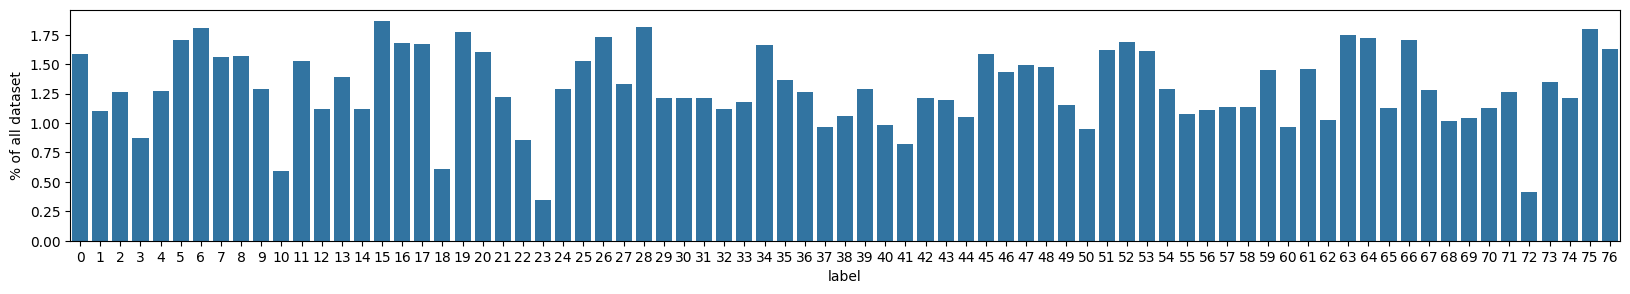

In [4]:
grouped_by = (
    df_raw.groupby("label").count().reset_index().rename(columns={"text": "count"})
)
total = grouped_by["count"].sum()
grouped_by["% of all dataset"] = grouped_by["count"] / total * 100

sns.barplot(data=grouped_by, y="% of all dataset", x="label")

fig = plt.gcf()
fig.set_size_inches(20, 3)

Text(0.5, 1.0, 'Distribution of Text Lengths')

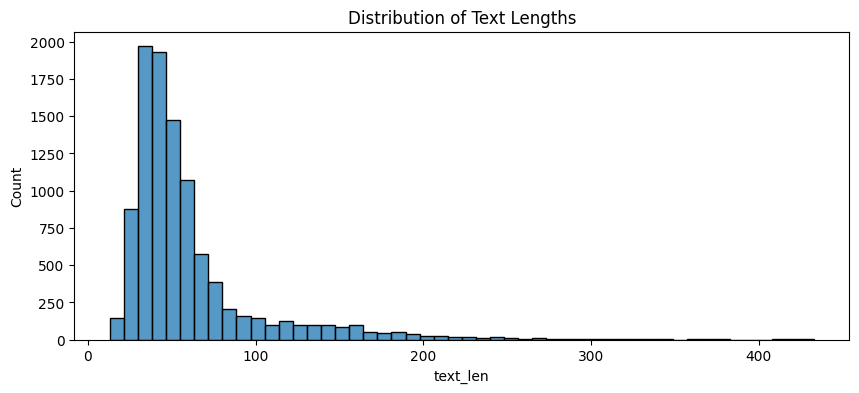

In [5]:
df_raw["text_len"] = df_raw["text"].str.len()

# Plot histogram using seaborn
plt.figure(figsize=(10, 4))
sns.histplot(data=df_raw, x="text_len", bins=50)
plt.title("Distribution of Text Lengths")

## CleanLab

In [6]:
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict


def get_initial_model_data(
    texts: np.ndarray, labels: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    transformer = SentenceTransformer("all-mpnet-base-v2")
    embeddings = transformer.encode(texts)
    model = LogisticRegression(class_weight="balanced")
    pred_probs = cross_val_predict(
        estimator=model, X=embeddings, y=labels, method="predict_proba"
    )

    return embeddings, pred_probs

In [7]:
texts = df_raw["text"].values
labels = df_raw["label"].values

embeddings, pred_probs = get_initial_model_data(texts, labels)

In [8]:
from cleanlab import Datalab


data_dict = {"texts": texts, "labels": labels}
lab = Datalab(data_dict, label_name="labels", task="classification")
lab.find_issues(pred_probs=pred_probs, features=embeddings)
lab.report()

Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 676 issues found in the dataset.
Dataset Information: num_examples: 10003, num_classes: 77

Here is a summary of various issues found in your data:

    issue_type  num_issues
near_duplicate         376
         label         163
       outlier         136
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


------------------ near_duplicate issues -------------------

About this issue:
	A (near) duplicate issue refers to two or more examples in
    a dataset that are extremely similar to each other, relative
  

### labels

In [9]:
label_issues = lab.get_issues("label")
label_issues = label_issues[label_issues["is_label_issue"]]

idxs = label_issues.index.tolist()
pred_labels = label_issues["predicted_label"]

df_fixed_labels = df_raw.copy()
df_fixed_labels.loc[idxs, "label"] = pred_labels

In [60]:
df_raw.loc[idxs, "label"].value_counts()

label
7     13
27    12
47    10
61    10
66    10
67     9
76     7
48     7
64     6
5      6
65     5
26     5
54     5
53     5
59     4
16     4
11     4
42     3
12     3
14     3
68     3
74     3
17     2
49     2
19     2
57     2
41     2
50     2
28     2
56     2
73     2
25     2
51     2
2      2
37     1
29     1
Name: count, dtype: int64

### duplicates

In [10]:
duplicate_issues = lab.get_issues("near_duplicate")
duplicate_issues = duplicate_issues[duplicate_issues["is_near_duplicate_issue"]]
duplicate_issues = duplicate_issues.sort_values(by="near_duplicate_score")

for idx, row in duplicate_issues.head(10).iterrows():
    text = texts[idx]
    neighbors = texts[row["near_duplicate_sets"][:3]]
    print(f"[IDX: {idx}] Text: {text}")
    print(f"\tDuplicates [{row['near_duplicate_sets'][:3]}]: {neighbors}")
    print()

[IDX: 1246] Text: I can't seem to be able to use my card
	Duplicates [[1290]]: ["\nI can't seem to be able to use my card\n\n\n"]

[IDX: 1290] Text: 
I can't seem to be able to use my card



	Duplicates [[1246]]: ["I can't seem to be able to use my card"]

[IDX: 6910] Text: Do I need to go to a physical bank to change my PIN?
	Duplicates [[6965]]: ['\nDo I need to go to a physical bank to change my PIN?']

[IDX: 1724] Text: I put the wrong pin too many times and now it is blocked. Can you help me unblock it?
	Duplicates [[1710]]: ['\nI put the wrong pin too many times and now it is blocked. Can you help me unblock it?']

[IDX: 1710] Text: 
I put the wrong pin too many times and now it is blocked. Can you help me unblock it?
	Duplicates [[1724]]: ['I put the wrong pin too many times and now it is blocked. Can you help me unblock it?']

[IDX: 4594] Text: Where can I withdraw money from?
	Duplicates [[4595]]: ['\nWhere can I withdraw money from?']

[IDX: 6965] Text: 
Do I need to go to a

In [11]:
def keep_one_from_duplicates(df: pd.DataFrame):
    seen = set()
    erase_rows = []

    for _, row in df.iterrows():
        dup_ids = row["near_duplicate_sets"]

        rep_id = row["index"]
        if rep_id in seen:
            continue

        if isinstance(dup_ids, np.ndarray):
            dup_ids = dup_ids.tolist()
        seen.update(dup_ids)

        erase_rows.extend(dup_ids)

    return erase_rows


duplicates_to_delete = keep_one_from_duplicates(duplicate_issues.reset_index())

### outliers

In [12]:
lab_outliers = lab.get_issues("outlier")
lab_outliers = lab_outliers[lab_outliers["is_outlier_issue"]]
outliers_to_delete = lab_outliers.index.tolist()

In [61]:
rows_to_delete = list(set(outliers_to_delete + duplicates_to_delete))
df_fixed = df_fixed_labels.drop(rows_to_delete).reset_index(drop=True)

In [89]:
# similarity problem
print(df_raw.loc[rows_to_delete, "label"].value_counts().sort_values().iloc[-5:])

# label problem
print(df_raw.loc[idxs, "label"].value_counts().sort_values().iloc[-5:])

label
28     7
59     8
1      9
50    10
24    11
Name: count, dtype: int64
label
66    10
61    10
47    10
27    12
7     13
Name: count, dtype: int64


### comment

by looking at the overall counts the errors seems to align partially with the paper. the `transfer_not_received_by_recipient` label was both in our case and in paper most troublesome. `pending_top_up` also showed up on podium. But the counts are not very simmilar (in the paper they show 2-3 times more problems)

## Text classifier

In [14]:
import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split


# 60-10-30% split
test_size = 0.2
train_size = 0.8
df_train, df_test = train_test_split(
    df_fixed, test_size=test_size, random_state=0, stratify=df_fixed["label"]
)
df_train, df_valid = train_test_split(
    df_train, train_size=train_size, random_state=0, stratify=df_train["label"]
)

datasets_dict = DatasetDict()
datasets_dict["train"] = Dataset.from_pandas(df_train, split="train")
datasets_dict["valid"] = Dataset.from_pandas(df_valid, split="valid")
datasets_dict["test"] = Dataset.from_pandas(df_test, split="test")

In [15]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def tokenize(examples: dict) -> dict:
    encoded_examples = tokenizer(examples["text"], padding=True, truncation=True)
    encoded_examples["label"] = torch.tensor(examples["label"])
    return encoded_examples


num_cores = joblib.cpu_count(only_physical_cores=True)
datasets_tokenized = datasets_dict.map(tokenize, batched=True)

Map:   0%|          | 0/6188 [00:00<?, ? examples/s]

Map:   0%|          | 0/1548 [00:00<?, ? examples/s]

Map:   0%|          | 0/1934 [00:00<?, ? examples/s]

In [29]:
import os
import random

from sklearn.metrics import f1_score, matthews_corrcoef
from torch.nn.functional import softmax
from transformers import (
    AutoModelForSequenceClassification,
    EvalPrediction,
    Trainer,
    TrainingArguments,
)


os.environ["PYTHONHASHSEED"] = str(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=77
)


def compute_metrics(eval_pred: EvalPrediction) -> dict:
    y_true = eval_pred.label_ids.ravel()
    logits = torch.from_numpy(eval_pred.predictions)
    y_pred = logits.argmax(dim=1)

    f1 = f1_score(y_true, y_pred, average="macro")
    return {"F1": f1}


training_args = TrainingArguments(
    per_device_train_batch_size=64,
    output_dir="finetuned_model_hw",
    learning_rate=3e-5,  # decreased lr and made more epochs
    num_train_epochs=6,
    logging_strategy="steps",
    logging_steps=50,
    eval_strategy="steps",
    save_steps=50,
    eval_steps=50,
    save_total_limit=1,
    load_best_model_at_end=True,
    seed=0,
    data_seed=0,
    fp16=True,
    dataloader_num_workers=1,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets_tokenized["train"],
    eval_dataset=datasets_tokenized["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1
50,4.208700,3.916283,0.249786
100,3.670900,3.251694,0.434834
150,3.061400,2.684797,0.542844
200,2.554500,2.231766,0.599156
250,2.151000,1.873144,0.646043
300,1.844600,1.610870,0.715943
350,1.579300,1.404667,0.755306
400,1.398100,1.260363,0.772641
450,1.256800,1.154526,0.792275
500,1.141600,1.089057,0.813514


TrainOutput(global_step=582, training_loss=2.1178679777584533, metrics={'train_runtime': 2199.3825, 'train_samples_per_second': 16.881, 'train_steps_per_second': 0.265, 'total_flos': 942642826306272.0, 'train_loss': 2.1178679777584533, 'epoch': 6.0})

In [30]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score


pred_output = trainer.predict(datasets_tokenized["test"])
logits = torch.from_numpy(pred_output.predictions)
y_pred = logits.argmax(dim=1)
y_test = datasets_tokenized["test"]["label"]

In [28]:
print(f"Precision\t: {precision_score(y_test, y_pred, average='macro'):.2%}")
print(f"Recall\t: {recall_score(y_test, y_pred, average='macro'):.2%}")
print(f"F1-score\t\t: {f1_score(y_test, y_pred, average='macro'):.2%}")
print(f"AUROC\t\t: {roc_auc_score(y_test, softmax(logits), multi_class='ovo'):.2%}")
print(f"MCC\t\t: {matthews_corrcoef(y_test, y_pred):.2%}")

Precision	: 63.99%
Recall	: 60.97%
F1-score		: 58.05%
AUROC		: 99.04%
MCC		: 64.87%


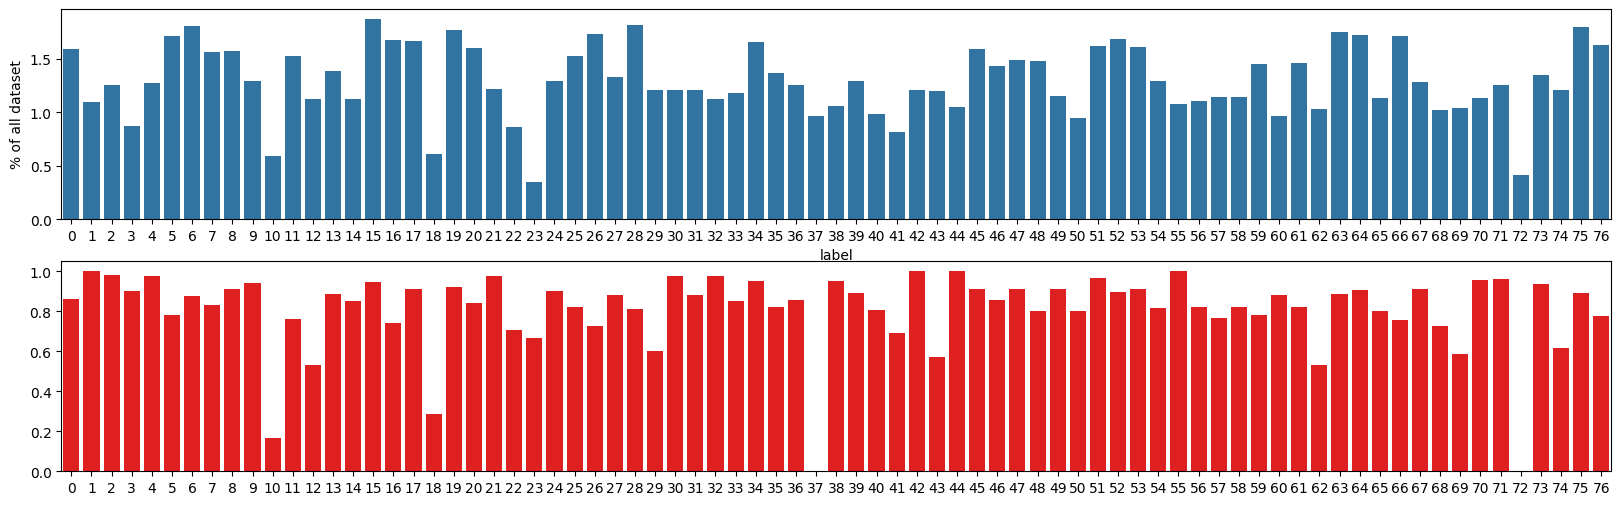

In [52]:
f1_per_class = f1_score(y_test, y_pred, average=None)
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(20, 6)
sns.barplot(x=list(range(77)), y=f1_per_class, ax=ax[1], color="red")
sns.barplot(data=grouped_by, y="% of all dataset", x="label", ax=ax[0])
plt.show()

### comment

I feel that the F1 score per class does look good but one thing. The problematic few class makes the overall looks worse, despite the fact that their part of the dataset is small. But the fact that there are 4 classes below .5 F1 makes it very hard to defend.

## Behavioral testing with Giscard

In [44]:
from giskard import Model as GiskardModel, Dataset as GiskardDataset, scan

trained_model = trainer.model
trained_model.eval()


@torch.no_grad()
def prediction_function(df: pd.DataFrame) -> np.ndarray:
    # tokenize
    inputs = tokenizer(
        df["text"].tolist(), padding=True, truncation=True, return_tensors="pt"
    ).to(trained_model.device)

    outputs = trained_model(**inputs)

    probs = torch.softmax(outputs.logits, dim=1)

    return probs.cpu().numpy()


giskard_dataset = GiskardDataset(df_test, target="label")

giskard_model = GiskardModel(
    model=prediction_function,
    model_type="classification",
    classification_labels=list(range(77)),
    feature_names=["text"],
)
scan_results = scan(giskard_model, giskard_dataset, verbose=False)
display(scan_results)

2025-11-23 17:26:06,667 pid:9294 MainThread giskard.datasets.base INFO     Your 'pandas.DataFrame' is successfully wrapped by Giskard's 'Dataset' wrapper class.
2025-11-23 17:26:06,668 pid:9294 MainThread giskard.models.automodel INFO     Your 'prediction_function' is successfully wrapped by Giskard's 'PredictionFunctionModel' wrapper class.
2025-11-23 17:26:06,690 pid:9294 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-23 17:26:06,880 pid:9294 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (10, 3) executed in 0:00:00.204949
2025-11-23 17:26:06,892 pid:9294 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-23 17:26:06,906 pid:9294 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1, 3) executed in 0:00:00.024041
2025-11-23 17:26:06,915 pid:9294 MainThread giskard.datasets.base INFO   

<iframe id="scan-130631724719312" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collaps

### comment
Seems that our model is biased toward few words, and whats worse - not stable when it comes to the typos. That might be a problem with small dataset or maybe a bit overtrained model (but the metrics doesn't show that, so I have no way to prove it)

Still there seems to be a duplicants problem, because the last error shows problem of data leakage

## Explainablility

In [105]:
name_of_the_label = {
    0: "activate_my_card",
    1: "age_limit",
    2: "apple_pay_or_google_pay",
    3: "atm_support",
    4: "automatic_top_up",
    5: "balance_not_updated_after_bank_transfer",
    6: "balance_not_updated_after_cheque_or_cash_deposit",
    7: "beneficiary_not_allowed",
    8: "cancel_transfer",
    9: "card_about_to_expire",
    10: "card_acceptance",
    11: "card_arrival",
    12: "card_delivery_estimate",
    13: "card_linking",
    14: "card_not_working",
    15: "card_payment_fee_charged",
    16: "card_payment_not_recognised",
    17: "card_payment_wrong_exchange_rate",
    18: "card_swallowed",
    19: "cash_withdrawal_charge",
    20: "cash_withdrawal_not_recognised",
    21: "change_pin",
    22: "compromised_card",
    23: "contactless_not_working",
    24: "country_support",
    25: "declined_card_payment",
    26: "declined_cash_withdrawal",
    27: "declined_transfer",
    28: "direct_debit_payment_not_recognised",
    29: "disposable_card_limits",
    30: "edit_personal_details",
    31: "exchange_charge",
    32: "exchange_rate",
    33: "exchange_via_app",
    34: "extra_charge_on_statement",
    35: "failed_transfer",
    36: "fiat_currency_support",
    37: "get_disposable_virtual_card",
    38: "get_physical_card",
    39: "getting_spare_card",
    40: "getting_virtual_card",
    41: "lost_or_stolen_card",
    42: "lost_or_stolen_phone",
    43: "order_physical_card",
    44: "passcode_forgotten",
    45: "pending_card_payment",
    46: "pending_cash_withdrawal",
    47: "pending_top_up",
    48: "pending_transfer",
    49: "pin_blocked",
    50: "receiving_money",
    51: "Refund_not_showing_up",
    52: "request_refund",
    53: "reverted_card_payment?",
    54: "supported_cards_and_currencies",
    55: "terminate_account",
    56: "top_up_by_bank_transfer_charge",
    57: "top_up_by_card_charge",
    58: "top_up_by_cash_or_cheque",
    59: "top_up_failed",
    60: "top_up_limits",
    61: "top_up_reverted",
    62: "topping_up_by_card",
    63: "transaction_charged_twice",
    64: "transfer_fee_charged",
    65: "transfer_into_account",
    66: "transfer_not_received_by_recipient",
    67: "transfer_timing",
    68: "unable_to_verify_identity",
    69: "verify_my_identity",
    70: "verify_source_of_funds",
    71: "verify_top_up",
    72: "virtual_card_not_working",
    73: "visa_or_mastercard",
    74: "why_verify_identity",
    75: "wrong_amount_of_cash_received",
    76: "wrong_exchange_rate_for_cash_withdrawal",
}

In [113]:
from copy import deepcopy

from captum.attr import InputXGradient, configure_interpretable_embedding_layer
from captum.attr import visualization as vis


class BERTModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs, attention_mask):
        return self.model(inputs, attention_mask=attention_mask)[0]


def explain_text(model, text: str, y_true: int, legend=False) -> None:
    # make sure we compute gradients as necessary
    for param in model.distilbert.parameters():
        param.requires_grad = True

    tokenizer_output = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer_output = tokenizer_output.to(device)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer_output["input_ids"][0])

    model_copy = deepcopy(model)
    interpretable_embedding_layer = configure_interpretable_embedding_layer(
        model_copy, "distilbert.embeddings"
    )
    input_embeddings = interpretable_embedding_layer.indices_to_embeddings(
        tokenizer_output["input_ids"]
    )

    model_wrapper = BERTModelWrapper(model_copy)
    input_x_gradient = InputXGradient(model_wrapper)
    attributions = input_x_gradient.attribute(
        input_embeddings,
        target=1,
        additional_forward_args=tokenizer_output["attention_mask"],
    )

    # mean normalization
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = list([float(attr) for attr in attributions])

    with torch.no_grad():
        logits = model(**tokenizer_output).logits
        y_pred_proba = softmax(logits, dim=1).argmax(dim=1).item()
        y_pred = int(logits.argmax(dim=1))

    # remove [CLS] and [SEP] tokens
    attributions = attributions[1:-1]
    tokens = tokens[1:-1]

    vis_record = vis.VisualizationDataRecord(
        word_attributions=attributions,
        pred_prob=y_pred_proba,
        pred_class=name_of_the_label[y_pred],
        true_class=name_of_the_label[y_true],
        attr_class=1,
        attr_score=sum(attributions),
        raw_input_ids=tokens,
        convergence_score=0,
    )

    vis.visualize_text([vis_record], legend=legend)

In [114]:
for counter in range(20):
    explain_text(
        model, datasets_dict["test"]["text"][counter], y_test[counter], counter == 0
    )

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
passcode_forgotten,passcode_forgotten (44.00),1,0.80,lost password


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
reverted_card_payment?,reverted_card_payment? (53.00),1,1.20,my payment was terminated


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
disposable_card_limits,disposable_card_limits (29.00),1,0.20,how many times can i use my di ##sp ##osa ##ble card ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
wrong_exchange_rate_for_cash_withdrawal,wrong_exchange_rate_for_cash_withdrawal (76.00),1,0.60,"when i got my cash , the amount was not what it should have been , based on the exchange rate ."


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
getting_virtual_card,getting_virtual_card (40.00),1,-1.06,where can virtual cards be ordered ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
order_physical_card,order_physical_card (43.00),1,-0.05,is a physical card also available


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
transfer_timing,transfer_timing (67.00),1,0.72,i urgently need to transfer something from china . how long can i expect it to take ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
order_physical_card,getting_spare_card (39.00),1,-0.63,is there a fee for physical cards ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
cash_withdrawal_charge,cash_withdrawal_charge (19.00),1,0.72,the bank charged me fees for withdrawing cash !


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
extra_charge_on_statement,extra_charge_on_statement (34.00),1,0.68,why is there an additional fee showing on the statement i received ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_delivery_estimate,order_physical_card (43.00),1,0.98,can you express my card to me ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
atm_support,atm_support (3.00),1,0.03,where can i find a master ##card atm ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_payment_not_recognised,card_payment_not_recognised (16.00),1,0.08,i do not recognize the card payment .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
transfer_fee_charged,transfer_fee_charged (64.00),1,-0.30,please explain the fee on a transfer i made .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
get_disposable_virtual_card,disposable_card_limits (29.00),1,0.11,can you tell me more info about virtual di ##sp ##osa ##ble cards ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
activate_my_card,activate_my_card (0.00),1,0.03,i tired but an unable to activate my card .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
wrong_amount_of_cash_received,wrong_amount_of_cash_received (75.00),1,1.30,the amount of money i pushed at the atm machine did not come out of the machine .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
top_up_by_card_charge,top_up_by_card_charge (57.00),1,0.63,is there a fee for topping up a card ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_payment_wrong_exchange_rate,card_payment_wrong_exchange_rate (17.00),1,0.77,"last saturday , i was charged extra for the exchange rate on my payment . is something wrong ?"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_arrival (11.00),1,0.27,how can i track card you sent


### comment
Most of the explanations make sense. certain words that exacly mean what class should have (like `top_up`, `virtual_card`, `transfer_fee`). For some reason there are still examples like `physical_card` that make no sense, but